## Setup autoreload, warnings and helper functions

In [18]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set the visibility of cuda devices (in case your system contains more than one)

In [19]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Imports

In [20]:
%matplotlib inline
from config import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import zipfile
import tensorflow as tf
import wget
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import COCOImageDataset, DatasetSlice

from tools import apply_pipeline, crop_step, curry, apply_pipeline_cocodataset, get_save_step
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from reidentification.identify import encode_single, encode_pipeline, create_database, identify, identify_single
from reidentification.visualisation import visualise_match
from simple_database import SimpleDatabase

## Create a configuration file.
You can change the default parameters in config.py

In [21]:
cfg = config()

/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:71: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.9)
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
/ekaterina/env/norppa/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Download the dataset

In [22]:
dataset_dir = Path(cfg["dataset_dir"])

if not dataset_dir.exists():
    
    print("Download and extract dataset")
    # Get a single use download link from https://etsin.fairdata.fi/dataset/22b5191e-f24b-4457-93d3-95797c900fc0/data
    # You will only need "full images.zip" for the reidentification, generate a link to that.
    dataset_url = ""
    
    print(f'Creating directory "{dataset_dir}"')
    dataset_dir.mkdir(parents=True, exist_ok=True)
    
    file = wget.download(dataset_url.replace(" ", "%20"), out=str(dataset_dir))
    print()
    print(f'Extracting "{file}"')
    zip_f = zipfile.ZipFile(file, 'r')
    zip_f.extractall(dataset_dir)
    zip_f.close()
    Path(file).unlink()

print(f'SealID dataset is ready')

SealID dataset is ready


## Create dataset variables

In [23]:
dataset_dir = Path(cfg["dataset_dir"])/"full images"

database_dataset = COCOImageDataset(dataset_dir/"source_database", dataset_dir/"annotation.csv", "database")
query_dataset = COCOImageDataset(dataset_dir/"source_query", dataset_dir/"annotation.csv", "query")


segmented_database_dataset = COCOImageDataset(dataset_dir/"segmented_database", dataset_dir/"annotation.csv", "database")
segmented_query_dataset = COCOImageDataset(dataset_dir/"segmented_query", dataset_dir/"annotation.csv", "query")

img_data = query_dataset[3]
print(img_data)

(<PIL.Image.Image image mode=RGB size=958x600 at 0x7F3FF7399050>, {'class_id': '1', 'file': '/ekaterina/work/src/NORPPA/repository/NORPPA/data/full images/source_query/ggbxhv.jpg'})


## Show an image from the dataset

# Input image

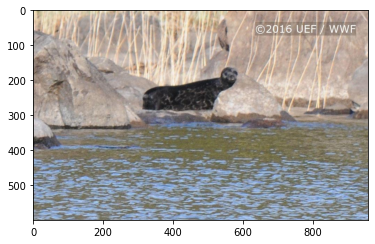

In [24]:
img, label = img_data

print_heading("Input image")
plt.imshow(img)
plt.show()

## Apply tonemapping

completed 100%


# Tonemapped image

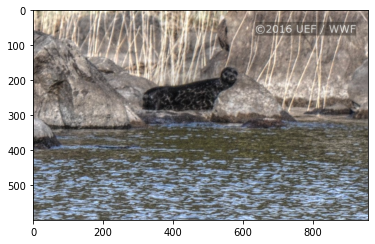

In [25]:
# Remember to install pfstmo package with
# sudo apt-get install pfstmo

tonemapped_img = tonemap(img)

print_heading("Tonemapped image")
plt.imshow(tonemapped_img)
plt.show()

## Segment and crop an image

/ekaterina/env/norppa/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


# Segmented image

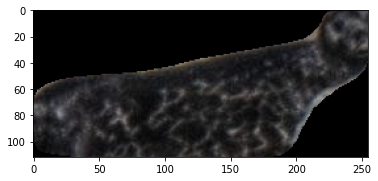

In [26]:
segment_step = curry(segment, cfg["detectron_predictor"], instance_segmentation=False)

segmented_img, label = apply_pipeline(tonemapped_img, label, [segment_step, crop_step])[0]

print_heading("Segmented image")
plt.imshow(segmented_img)
plt.show()

## Extract pattern from an image

# Pattern image

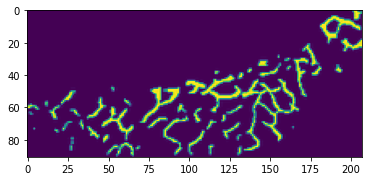

In [27]:
extract_pattern_step = curry(extract_pattern, model=cfg["unet"])

pattern_img, label = apply_pipeline(segmented_img, label, [extract_pattern_step])[0]

print_heading("Pattern image")
plt.imshow(pattern_img)
plt.show()

## Encode an image

In [28]:
encoded_img = encode_single(pattern_img, cfg)
print("Encoded image")

  0%|                                                     | 0/1 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

Calculating PCA
Getting encoding parameters...
Encoding...
Encoded image


## Create a small database for testing
This example uses a very simple database implemented as a Python class. The database might take a lot of space if all images are used, and in that case it is better to store it on a disc, e.g. with the help of SQL based database systems.

In [29]:
database_dataset_mini = DatasetSlice(database_dataset, range(20))

pipeline = [
            tonemap_step, 
            segment_step, crop_step,
            extract_pattern_step
            ]

pattern_dataset = apply_pipeline_cocodataset(database_dataset_mini, pipeline)

db_components, codebooks = create_database(pattern_dataset, cfg)

simple_db = SimpleDatabase(*db_components)
print("Created a test database")

completed 100%
/ekaterina/env/norppa/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
completed 100%
/ekaterina/env/norppa/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roun

TypeError: scandir: path should be string, bytes, os.PathLike, integer or None, not list

## Perform re-identification

In [ ]:
identification_result = identify([(encoded_img, label)], database=simple_db, cfg=cfg)

## Visualise re-identification results

In [ ]:
visualise_match(identification_result[0])
print()

## Apply full pipeline to another query image

In [ ]:
full_pipeline = [
            tonemap_step, 
            segment_step, crop_step,
            extract_pattern_step,
            curry(encode_pipeline, cfg=cfg),
            curry(identify_single, database=simple_db, cfg=cfg),
            visualise_match
            ]

apply_pipeline(*query_dataset[0], full_pipeline)
print()